In [71]:
from elasticsearch import Elasticsearch
from deepface import DeepFace
import matplotlib.pyplot as plt
from retinaface import RetinaFace
import os
import time
import glob
import cv2 as cv
from PIL import Image

In [51]:
es = Elasticsearch(hosts=['http://localhost:9200'], http_auth=('elastic', 'DkIed99SCb'))

In [52]:
model_name = 'ArcFace'
target_size = (160, 160)
embedding_size = 512

In [53]:
mapping = {
    "mappings": {
        "properties": {
            "title_vector":{
                "type": "dense_vector",
                "dims": embedding_size
            },
            "title_name": {"type": "keyword"},
            "description": {"type": "keyword"},
            "img_path": {"type": "keyword"},
            "gender": {"type": "keyword"},
            "dob": {"type": "date"},
            "birth_place": {"type": "keyword"},
            "image": {"type": "keyword"},
            "face": {"type": "keyword"},
            "identified_age": {"type": "Long"},
            "identified_gender": {"type": "keyword"},
            "identified_race": {"type": "keyword"},
            "identified_emotion": {"type": "keyword"},            
        }
    }
}
   
# es.indices.create(index="wikidb", body=mapping)

0.08096098899841309  seconds
33
Robert De Niro . Score:  1.7462499 public/data/Robert%20De%20Niro%20Cannes%202016.jpg


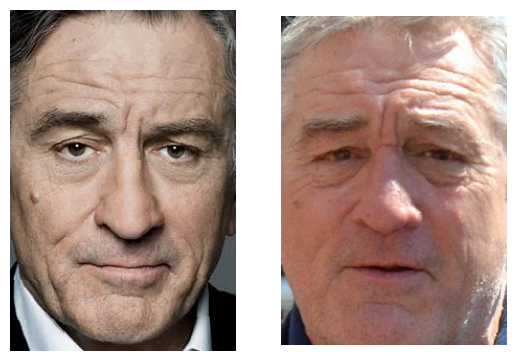

-------------------------
Robert De Niro . Score:  1.7462499 public/data/Robert%20De%20Niro%20Cannes%202016.jpg


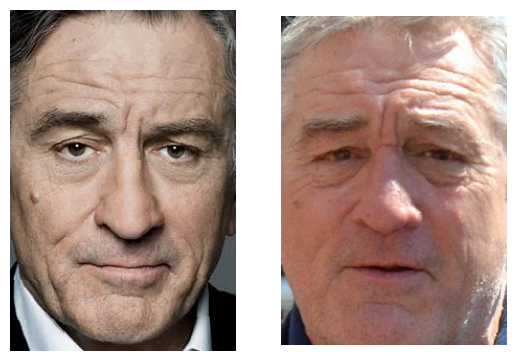

-------------------------
Tom Steyer . Score:  1.5606775 public/data/Tom%20Steyer%20by%20Gage%20Skidmore.jpg


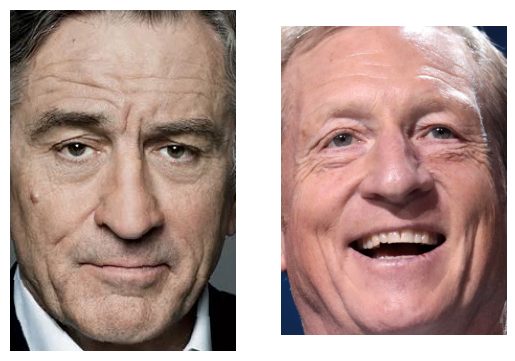

-------------------------
Frederic M. Richards . Score:  1.5374889 public/data/Fred%20Richards%20photo.png


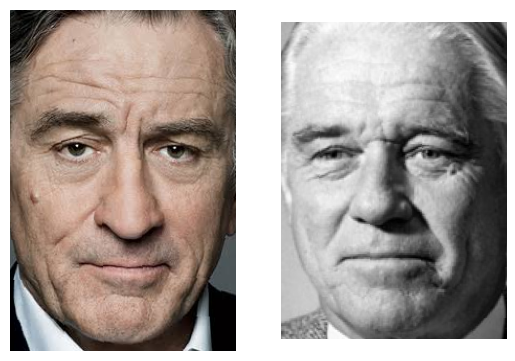

-------------------------
Ted Leonsis . Score:  1.5083189 public/data/Ted%20Leonsis%20headshot%202013.jpg


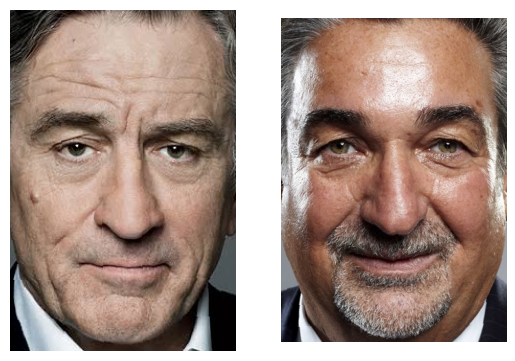

-------------------------
Yaakov Perlow . Score:  1.4938781 public/data/%D7%94%D7%A8%D7%91%20%D7%9E%D7%A0%D7%95%D7%91%D7%95%D7%9E%D7%99%D7%A0%D7%A1%D7%A7.jpg


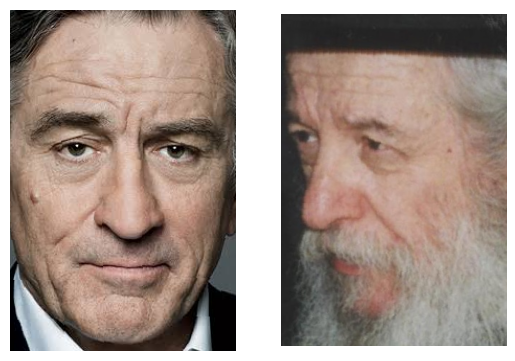

-------------------------
Garry Marshall . Score:  1.4931104 public/data/Garry%20Marshall%202013%20cropped.jpg


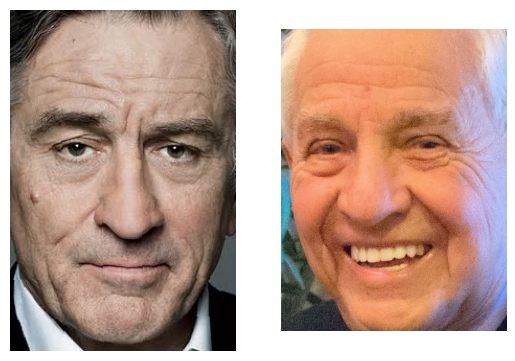

-------------------------
Red Holzman . Score:  1.4909163 public/data/Knicks%20coach%20Red%20Holzman.jpg


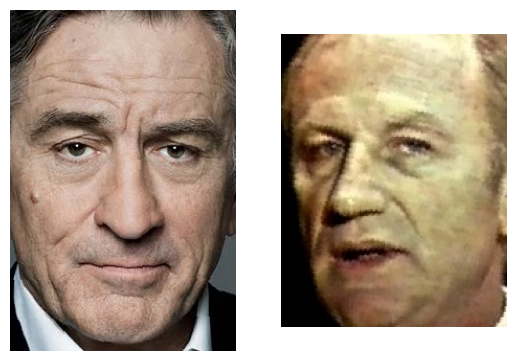

-------------------------
Walter Maslow . Score:  1.4838388 public/data/Walter%20Maslow%20in%20Man%20with%20a%20Camera%2C%201959.jpg


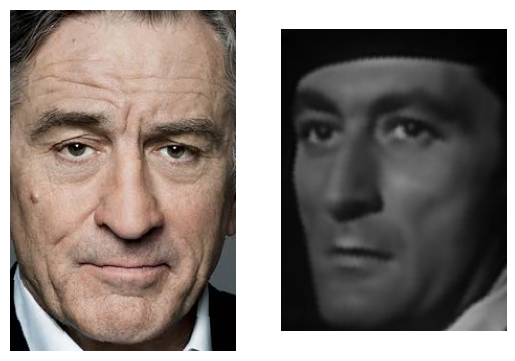

-------------------------
Carl Sharsmith . Score:  1.4524659 public/data/Carl%20Sharsmith.jpg


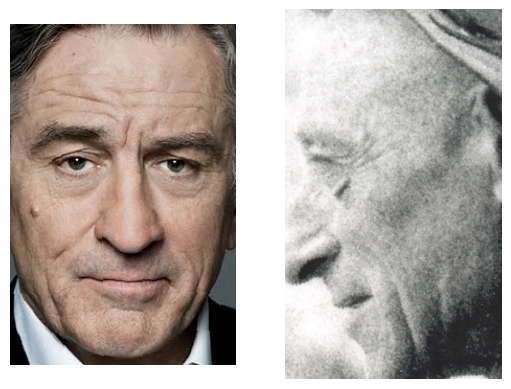

-------------------------


In [181]:
target_img_path = "dataset/targets/rdn.jpeg"
embedding_objs = DeepFace.represent(img_path = target_img_path, 
  model_name = 'Facenet512',
  detector_backend = 'retinaface',
  align = True
)
target_embedding = embedding_objs[0]["embedding"]

query = {
    "size": 10,
    "query": {
        "script_score": {
            "query": {
                # "match": {"gender": "female"},
                "match_all": {},
            },
            "script": {
                "source": "cosineSimilarity(params.queryVector, 'title_vector') + 1.0",
                # "source": "1 / (1 + l2norm(params.queryVector, 'title_vector'))", #euclidean distance
                "params": {
                    "queryVector": list(target_embedding)
                }
            }
        }
    }
}
# print(query)
tic = time.time()
res = es.search(index="facedb", body=query)
toc = time.time()

print(toc-tic," seconds")

target_faces = RetinaFace.extract_faces(img_path = target_img_path, align = True)
target_img = target_faces[0]
print(res['took'])
for i in res["hits"]["hits"]:
    candidate_name = i["_source"]["title_name"]
    img_path = i["_source"]["img_path"]
    candidate_score = i["_score"]
    print(candidate_name, ". Score: ", candidate_score, img_path)    
    try:
        candidate_img = Image.open(i["_source"]["face_path"])
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        plt.imshow(target_img)
        plt.axis('off')

        ax2 = fig.add_subplot(1, 2, 2)
        plt.imshow(candidate_img)
        plt.axis('off')

        plt.show()
    except:
        pass
    print("-------------------------")

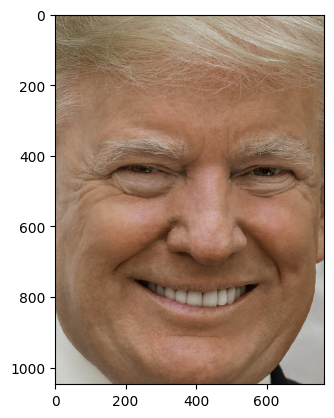

In [79]:
target_img_path = "public/data/Donald%20Trump%20official%20portrait.jpg"
embedding_objs = DeepFace.represent(img_path=img_path, model_name='ArcFace', detector_backend='retinaface', align=True)
target_faces = RetinaFace.extract_faces(img_path = target_img_path, align = True)
target_img = target_faces[0]
plt.imshow(target_img)
plt.show()

# cv.imwrite(target_img_path+".thumb.jpg", target_img[...,::-1])

In [39]:
objs = DeepFace.analyze(
  img_path = target_img_path, 
  actions = ['age', 'gender', 'race', 'emotion'],
  detector_backend='retinaface',
)
print(objs[0].get('age'))
print(objs[0].get('dominant_gender'))
print(objs[0].get('dominant_race'))
print(objs[0].get('dominant_emotion'))
objs


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

49
Man
white
happy


[{'age': 49,
  'region': {'x': 713,
   'y': 573,
   'w': 759,
   'h': 1042,
   'left_eye': (1327, 1013),
   'right_eye': (969, 1010)},
  'face_confidence': 1.0,
  'gender': {'Woman': 0.19123643869534135, 'Man': 99.80875849723816},
  'dominant_gender': 'Man',
  'race': {'asian': 19.371123611927032,
   'indian': 1.7208825796842575,
   'black': 0.5722124129533768,
   'white': 61.7558479309082,
   'middle eastern': 6.3774362206459045,
   'latino hispanic': 10.202499479055405},
  'dominant_race': 'white',
  'emotion': {'angry': 1.5084187154554285e-10,
   'disgust': 9.78146533735998e-16,
   'fear': 1.6119184369982158e-12,
   'happy': 100.0,
   'sad': 5.879682074549919e-07,
   'surprise': 7.514150506683474e-14,
   'neutral': 2.8419558262271494e-06},
  'dominant_emotion': 'happy'}]